In [1]:
import random, numpy as np, torch
seed = 42
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

RUN_NAME = "filtered_ae_mse_vae_bs256_ep20_sr8k_T4000" # 更新 RUN_NAME 以反映更改

In [2]:
import sys
import os, glob, random, json
import numpy as np
import matplotlib.pyplot as plt
import librosa

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm  # 用纯文本 tqdm，避免 ipywidgets warning


In [3]:
SAVE_DIR = "experiments"
os.makedirs(SAVE_DIR, exist_ok=True)

In [4]:
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

cuda available: True
GPU: NVIDIA A100-SXM4-40GB


In [ ]:

# from google.colab import drive
# drive.mount('/content/drive')
DATA_ROOT = r"C:\Users\11604\Desktop\thesis\hapticgen-dataset\expertvoted" 

def collect_clean_wavs(root):
    wavs = []
    for meta_path in glob.glob(os.path.join(root, "**/*.am1.json"), recursive=True):
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)

        # 用expertvoted里面的，这里目前全是initial
        if meta.get("model") == "HapticGen-Initial" and meta.get("vote") == 1:
            wav_path = os.path.join(os.path.dirname(meta_path), meta["filename"])
            if os.path.exists(wav_path):
                wavs.append(wav_path)

    return wavs

wav_files = collect_clean_wavs(DATA_ROOT)
print("Clean wavs:", len(wav_files))

assert len(wav_files) > 0, "没有筛选到任何 HapticGenInitial + vote=1 的 wav"


assert len(wav_files) > 0, "没找到任何 wav：请检查 DATA_ROOT 是否指向正确的根目录"

Mounted at /content/drive
Clean wavs: 585



--- The_feeling_of_drinking_cola._UMW33_1.wav
sr: 8000 len: 80000 min/max: -0.1484375 0.140625


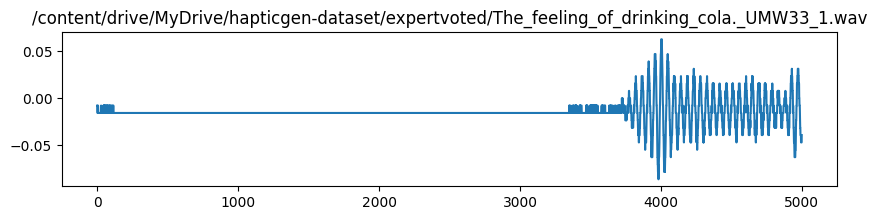


--- I_want_to_feel_like_I_m_shooting_a_machine_gun_for_SDGI6_5.wav
sr: 8000 len: 80000 min/max: -1.0 0.984375


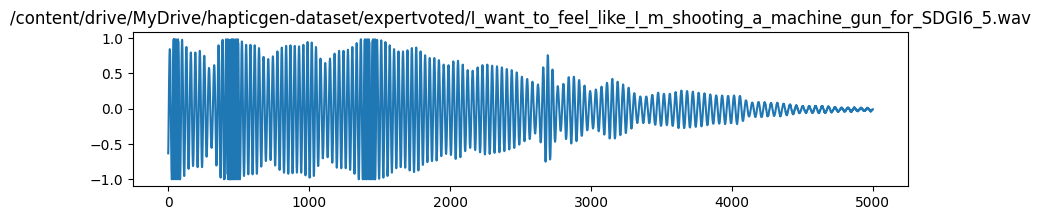


--- Hanging_on_to_a_cliff_WNNWYI_1.wav
sr: 8000 len: 80000 min/max: -0.328125 0.3125


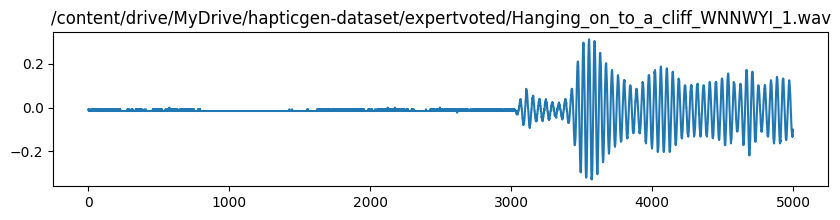

In [6]:
sample_wavs = random.sample(wav_files, 3)

for p in sample_wavs:
    y, sr = librosa.load(p, sr=None, mono=True)
    print("\n---", os.path.basename(p))
    print("sr:", sr, "len:", len(y), "min/max:", float(y.min()), float(y.max()))
    plt.figure(figsize=(10,2))
    plt.plot(y[:5000])
    plt.title(p)
    plt.show()


In [9]:
SR_EXPECT = 8000
T = 4000  # 0.5s @ 8kHz

USE_MINMAX = False  # ✅ 设为 False，禁用 min-max 归一化

def minmax_norm(seg):
    mn = seg.min()
    mx = seg.max()
    if mx - mn < 1e-8:
        return np.zeros_like(seg)
    return (seg - mn) / (mx - mn)   # [0,1]

def load_segment_energy(
    path, T=T, sr_expect=SR_EXPECT,
    tries=30, min_energy=5e-4, max_resample=5,
    fallback="best"   # "best" or "zeros"
):
    y, sr = librosa.load(path, sr=None, mono=True)
    if sr != sr_expect:
        y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)

    if len(y) < T:
        y = np.pad(y, (0, T - len(y)))

    max_start = len(y) - T  # >= 0

    best_seg_global = None
    best_energy_global = -1.0

    for _ in range(max_resample):
        best_seg = None
        best_energy = -1.0

        for _ in range(tries):
            start = np.random.randint(0, max_start + 1)
            seg = y[start:start+T]
            seg = seg - np.mean(seg)
            e = float(np.mean(seg**2))

            if e > best_energy:
                best_energy = e
                best_seg = seg

        # 记录全局最优（用于 fallback）
        if best_energy > best_energy_global:
            best_energy_global = best_energy
            best_seg_global = best_seg

        if best_energy >= min_energy:
            best_seg = best_seg_global  # 或 best_seg（两者此时一致/接近）
            break

    # ✅ 关键：不再 return None
    if best_seg_global is None:
        # 极端情况：文件读不到/空
        return np.zeros(T, dtype=np.float32)

    if best_energy_global < min_energy:
        if fallback == "zeros":
            return np.zeros(T, dtype=np.float32)
        # fallback == "best"：继续用能量最高的那段（即使低于门槛）

    # ===== 下面保持你原来的尺度归一化逻辑 =====
    SCALE = 0.25
    seg = best_seg_global / (GLOBAL_RMS + 1e-6)
    seg = seg * SCALE
    seg = np.clip(seg, -3.0, 3.0)

    if USE_MINMAX:
        seg = minmax_norm(seg)

    return seg.astype(np.float32)


In [10]:
N = len(wav_files)
perm = np.random.permutation(N)
train_idx = perm[:int(0.8 * N)]
val_idx   = perm[int(0.8 * N):]

train_files = [wav_files[i] for i in train_idx]
val_files   = [wav_files[i] for i in val_idx]

print("train:", len(train_files), "val:", len(val_files))

def estimate_global_rms(files, n=200, sr_expect=SR_EXPECT):
    picks = random.sample(files, min(n, len(files)))
    rms = []
    for p in picks:
        y, sr = librosa.load(p, sr=None, mono=True)
        if sr != sr_expect:
            y = librosa.resample(y, orig_sr=sr, target_sr=sr_expect)
        y = y - np.mean(y)
        rms.append(np.sqrt(np.mean(y**2)) + 1e-8)
    return float(np.median(rms))

GLOBAL_RMS = estimate_global_rms(train_files, n=200)
print("GLOBAL_RMS =", GLOBAL_RMS)

x = load_segment_energy(train_files[0], T=T)
print("seg std:", x.std(), "seg maxabs:", np.max(np.abs(x)))
x2 = load_segment_energy(train_files[1], T=T)
print("x2 is None?", x2 is None)
print("seg2 std:", np.std(x2), "seg2 maxabs:", np.max(np.abs(x2)))



class HapticWavDataset(Dataset):
    def __init__(self, files, T=4000):
        self.files = files
        self.T = T

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
    # 遇到 None（没找到足够能量的片段）就换文件重采样
        for _ in range(10):  # 最多尝试 10 次，避免死循环
          x = load_segment_energy(self.files[idx], T=self.T)
          if x is not None:
            return torch.from_numpy(x).unsqueeze(0)
          idx = np.random.randint(0, len(self.files))

    # 如果极端情况下 10 次都失败，返回全 0（保证类型正确）
        return torch.zeros(1, self.T, dtype=torch.float32)



batch_size = 256
train_loader = DataLoader(HapticWavDataset(train_files, T=T), batch_size=batch_size, shuffle=True, drop_last=True)
val_loader   = DataLoader(HapticWavDataset(val_files,   T=T), batch_size=batch_size, shuffle=False, drop_last=False)

# sanity check
xb = next(iter(train_loader))
print("batch shape:", xb.shape)  # (B, 1, T)


train: 468 val: 117
GLOBAL_RMS = 0.03169742226600647
seg std: 0.44906646 seg maxabs: 2.6179032
x2 is None? False
seg2 std: 2.0790648 seg2 maxabs: 3.0
batch shape: torch.Size([256, 1, 4000])


In [11]:
xb = next(iter(train_loader))  # (B,1,T)
stds = xb[:,0,:].numpy().std(axis=1)
print("silent-ish ratio:", (stds < 1e-3).mean())
print("std min/median/max:", stds.min(), np.median(stds), stds.max())


silent-ish ratio: 0.0
std min/median/max: 0.042188626 0.56907165 2.824326


In [30]:
def GN(c):
    return nn.GroupNorm(num_groups=8, num_channels=c)

class ConvVAE(nn.Module):
    def __init__(self, T=4000, latent_dim=32, logvar_clip=(-10, 10)):
        super().__init__()
        self.T = T
        self.latent_dim = latent_dim
        self.logvar_clip = logvar_clip

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=25, stride=2, padding=12),
            GN(16), nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=9, stride=2, padding=4),
            GN(32), nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=9, stride=2, padding=4),
            GN(64), nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, T)
            h = self.encoder(dummy)
            self.enc_shape = h.shape[1:]
            self.enc_feat = h.numel()

        self.fc_mu     = nn.Linear(self.enc_feat, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_feat, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, self.enc_feat)

        # 使用 xavier 初始化，不要用零初始化权重
        nn.init.xavier_uniform_(self.fc_mu.weight)
        nn.init.zeros_(self.fc_mu.bias)
        nn.init.xavier_uniform_(self.fc_logvar.weight)
        nn.init.constant_(self.fc_logvar.bias, -1.0)  # 初始化为较小的方差

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(64, 32, kernel_size=9, stride=2, padding=4, output_padding=1),
            GN(32), nn.ReLU(),
            nn.ConvTranspose1d(32, 16, kernel_size=9, stride=2, padding=4, output_padding=1),
            GN(16), nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=9, stride=2, padding=4, output_padding=1),
        )

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, self.logvar_clip[0], self.logvar_clip[1])
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std, logvar

    def forward(self, x):
        h = self.encoder(x)
        h_flat = h.view(h.size(0), -1)

        mu = self.fc_mu(h_flat)
        logvar_raw = self.fc_logvar(h_flat)
        z, logvar = self.reparameterize(mu, logvar_raw)

        h2 = self.fc_dec(z).view(x.size(0), *self.enc_shape)
        x_hat = self.decoder(h2)

        T = x.shape[-1]
        if x_hat.shape[-1] > T:
            x_hat = x_hat[..., :T]
        elif x_hat.shape[-1] < T:
            x_hat = torch.nn.functional.pad(x_hat, (0, T - x_hat.shape[-1]))

        return x_hat, mu, logvar, z


In [31]:
ckpt_path = f"{SAVE_DIR}/ckpt_{RUN_NAME}.pt"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

latent_dim = 16  # 减小潜在维度，更适合小数据集
model = ConvVAE(T=T, latent_dim=latent_dim).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

def kl_divergence_free_bits(mu, logvar, free_bits=0.25):
    """
    Free-bits KL: 每个维度至少允许 free_bits nats 的信息
    防止后验坍塌
    """
    # 每个维度的 KL
    kl_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())  # (B, latent_dim)
    # 对每个维度应用 free_bits 门槛
    kl_per_dim = torch.clamp(kl_per_dim, min=free_bits)
    # 对维度求和，对 batch 求平均
    return kl_per_dim.sum(dim=1).mean()


def cyclical_beta_schedule(epoch, total_epochs, n_cycles=3, ratio=0.5, beta_max=0.005):
    """
    Cyclical annealing: beta 周期性从 0 上升到 beta_max
    - n_cycles: 周期数
    - ratio: 每个周期中上升阶段的比例
    """
    cycle_length = total_epochs / n_cycles
    cycle_pos = epoch % cycle_length
    
    if cycle_pos / cycle_length < ratio:
        # 上升阶段
        return beta_max * (cycle_pos / (cycle_length * ratio))
    else:
        # 保持阶段
        return beta_max


total_epochs = 60  # 小数据集不需要太多轮
print_every = 5
patience = 15  # early stopping
min_delta = 1e-4

train_losses, val_losses = [], []
best_val = float("inf")
best_state = None
wait = 0


device: cuda
ConvVAE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(25,), stride=(2,), padding=(12,))
    (1): GroupNorm(8, 16, eps=1e-05, affine=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): GroupNorm(8, 32, eps=1e-05, affine=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): GroupNorm(8, 64, eps=1e-05, affine=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=32000, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=32000, out_features=64, bias=True)
  (fc_dec): Linear(in_features=64, out_features=32000, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): ReLU()
    (3): ConvTranspose1d(32, 16, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (4): GroupNorm(8, 16, eps=1e-05, affine=True)
    

In [32]:
print("train batches:", len(train_loader), "val batches:", len(val_loader))
print("train size:", len(train_loader.dataset), "val size:", len(val_loader.dataset))
print("one val batch shape:", next(iter(val_loader)).shape)



train batches: 1 val batches: 1
train size: 468 val size: 117
one val batch shape: torch.Size([117, 1, 4000])


In [39]:

def run_epoch(loader, train=True, epoch=1):
    model.train(train)
    total_loss = 0.0
    count = 0

    mode = "train" if train else "val"
    if len(loader) == 0:
        raise ValueError("val_loader is empty (len==0). Check your val split / DataLoader.")

    pbar = tqdm(loader, leave=False, desc=f"{mode} epoch {epoch}")

    for batch_idx, x in enumerate(pbar):
        x = x.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        x_hat_raw, mu, logvar, z = model(x)
        if batch_idx == 0:
          print(f"RAW x_hat stats [{mode.upper()}]:",
          "min =", x_hat_raw.detach().min().item(),
          "max =", x_hat_raw.detach().max().item(),
          "mean =", x_hat_raw.detach().mean().item(),
          "std =", x_hat_raw.detach().std().item())

        x_hat = 3.0 * torch.tanh(x_hat_raw / 3.0) # 换成平滑有梯度的squash

        mse = torch.nn.functional.mse_loss(x_hat, x)
        l1  = torch.nn.functional.l1_loss(x_hat, x)
        recon = mse + 0.2 * l1

        # 使用 free-bits KL 防止后验坍塌
        kl = kl_divergence_free_bits(mu, logvar, free_bits=0.25)
        
        # 使用 cyclical annealing
        beta = cyclical_beta_schedule(epoch, total_epochs, n_cycles=3, ratio=0.5, beta_max=0.005)
        
        # VAE 损失 = 重建损失 + beta * KL散度
        loss = recon + beta * kl


        # ✅ 只在非有限时跳过
        if not torch.isfinite(loss):
            print("⚠️ non-finite loss, skip batch",
                  "recon=", recon.detach().item(),
                  "kl=", kl.detach().item(),
                  "beta=", beta,
                  "logvar min/max=", logvar.detach().min().item(), logvar.detach().max().item())
            continue

        # ✅ debug：只打印每个 epoch 的第一个 batch
        if batch_idx == 0:
            print(f"DEBUG {mode.upper()}:",
                  "x min/max", x.detach().min().item(), x.detach().max().item(),
                  "| x_hat min/max", x_hat.detach().min().item(), x_hat.detach().max().item(),
                  "| recon", recon.detach().item(),
                  "| kl", kl.detach().item(),
                  "| beta", beta)
            print("mu abs mean:", mu.detach().abs().mean().item(),
                  "logvar min/max:", logvar.detach().min().item(), logvar.detach().max().item())

        if train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        bs = x.shape[0]
        total_loss += loss.detach().item() * bs
        count += bs

        pbar.set_postfix(loss=f"{(total_loss/max(count,1)):.4f}",
                         recon=f"{recon.detach().item():.4f}",
                         kl=f"{kl.detach().item():.4f}",
                         beta=f"{beta:.1e}")

    return total_loss / max(count, 1)


# ========= training loop + early stopping =========
early_stop_start = 10   # ✅ 前10个epoch不early stop（建议）
best_val = float("inf") # 确保初始化正确
wait = 0

for epoch in range(1, total_epochs + 1):
    tr = run_epoch(train_loader, train=True,  epoch=epoch)
    va = run_epoch(val_loader,   train=False, epoch=epoch)

    train_losses.append(tr)
    val_losses.append(va)

    # ✅ scheduler 只在 va 有效时 step
    if np.isfinite(va):
        scheduler.step(va)
    lr = optimizer.param_groups[0]["lr"]

    if epoch % print_every == 0 or epoch == 1:
        overall = 100.0 * epoch / total_epochs
        print(f"[Epoch {epoch:03d}/{total_epochs} | overall {overall:5.1f}%] "
              f"lr={lr:.2e} | train={tr:.6f} | val={va:.6f}")

    # ✅ early stopping（warmup 后才启用）
    if epoch >= early_stop_start:
        if (not np.isfinite(va)):
            wait += 1
        elif va < best_val - min_delta:
            best_val = va
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
            torch.save(best_state, ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}, best val = {best_val:.6f}")
                break

print("✅ Best val:", best_val)
print("✅ Saved best model weights to:", ckpt_path)

# ========= load best =========
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()


RAW x_hat stats [TRAIN]: min = -2.7818984985351562 max = 4.1932902336120605 mean = 0.228281632065773 std = 0.3026804029941559
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -2.1879968643188477 2.654601812362671 | recon 1.7959511280059814 | kl 64.2258071899414 | beta 0.0
mu abs mean: 9.886552810668945 logvar min/max: -10.0 -5.013692378997803


RAW x_hat stats [VAL]: min = -2.485250234603882 max = 4.099409103393555 mean = 0.21511805057525635 std = 0.2854459285736084
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -2.038874864578247 2.633655548095703 | recon 1.714762568473816 | kl 61.44296646118164 | beta 0.0
mu abs mean: 9.659201622009277 logvar min/max: -10.0 -4.66097354888916
[Epoch 001/20 | overall   5.0%] lr=2.00e-04 | train=1.795951 | val=1.714763


RAW x_hat stats [TRAIN]: min = -2.5189545154571533 max = 4.123336315155029 mean = 0.21509559452533722 std = 0.28528138995170593
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -2.056873321533203 2.639104127883911 | recon 1.760440707206726 | kl 62.976402282714844 | beta 0.0
mu abs mean: 9.795604705810547 logvar min/max: -10.0 -4.7668304443359375


RAW x_hat stats [VAL]: min = -2.3063554763793945 max = 4.098880290985107 mean = 0.20182408392429352 std = 0.27081766724586487
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.9386674165725708 2.6335339546203613 | recon 1.698401927947998 | kl 60.949974060058594 | beta 0.0
mu abs mean: 9.631047248840332 logvar min/max: -10.0 -4.981448173522949


RAW x_hat stats [TRAIN]: min = -2.3480043411254883 max = 4.0955891609191895 mean = 0.20164480805397034 std = 0.270203173160553
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.962706446647644 2.6327786445617676 | recon 1.7232375144958496 | kl 63.17790985107422 | beta 0.0
mu abs mean: 9.823999404907227 logvar min/max: -10.0 -4.1006646156311035


RAW x_hat stats [VAL]: min = -2.025693416595459 max = 4.1479034423828125 mean = 0.188292995095253 std = 0.25665026903152466
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.7652311325073242 2.6446194648742676 | recon 1.7026188373565674 | kl 61.6024169921875 | beta 0.0
mu abs mean: 9.704362869262695 logvar min/max: -10.0 -5.583343505859375


RAW x_hat stats [TRAIN]: min = -2.046041965484619 max = 4.081155776977539 mean = 0.18807950615882874 std = 0.25666874647140503
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.7784812450408936 2.6294469833374023 | recon 1.571327805519104 | kl 63.220333099365234 | beta 0.0
mu abs mean: 9.827604293823242 logvar min/max: -10.0 -3.434978485107422


RAW x_hat stats [VAL]: min = -1.8538591861724854 max = 3.959968328475952 mean = 0.17467685043811798 std = 0.24488961696624756
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.6491036415100098 2.600343942642212 | recon 1.7191298007965088 | kl 60.951133728027344 | beta 0.0
mu abs mean: 9.652120590209961 logvar min/max: -10.0 -5.403858661651611


RAW x_hat stats [TRAIN]: min = -1.904876947402954 max = 4.198700428009033 mean = 0.17445722222328186 std = 0.24413342773914337
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.6843721866607666 2.655773878097534 | recon 1.915761113166809 | kl 64.36195373535156 | beta 0.0
mu abs mean: 9.935619354248047 logvar min/max: -10.0 -5.738735675811768


RAW x_hat stats [VAL]: min = -1.613213062286377 max = 3.9411659240722656 mean = 0.16081446409225464 std = 0.2331942468881607
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.473820686340332 2.595642566680908 | recon 1.752963662147522 | kl 60.923126220703125 | beta 0.0
mu abs mean: 9.647626876831055 logvar min/max: -10.0 -5.02587366104126
[Epoch 005/20 | overall  25.0%] lr=2.00e-04 | train=1.915761 | val=1.752964


RAW x_hat stats [TRAIN]: min = -1.6235729455947876 max = 4.137222766876221 mean = 0.1608588993549347 std = 0.23413445055484772
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.4816668033599854 2.6422314643859863 | recon 1.7620699405670166 | kl 63.48169708251953 | beta 0.0
mu abs mean: 9.852058410644531 logvar min/max: -10.0 -4.141679286956787


RAW x_hat stats [VAL]: min = -1.4440765380859375 max = 3.88112211227417 mean = 0.1475130170583725 std = 0.22366352379322052
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.341993808746338 2.5802831649780273 | recon 1.6260732412338257 | kl 61.25483703613281 | beta 0.0
mu abs mean: 9.66960334777832 logvar min/max: -10.0 -5.222245693206787


RAW x_hat stats [TRAIN]: min = -1.408199667930603 max = 3.973245859146118 mean = 0.1475449949502945 std = 0.22406016290187836
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.313143014907837 2.603633403778076 | recon 1.719904899597168 | kl 62.68305969238281 | beta 0.0
mu abs mean: 9.787577629089355 logvar min/max: -10.0 -5.093236923217773


RAW x_hat stats [VAL]: min = -1.0079210996627808 max = 3.789499521255493 mean = 0.1347835212945938 std = 0.21385745704174042
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.9716343879699707 2.5558042526245117 | recon 1.6370985507965088 | kl 60.46525573730469 | beta 0.0
mu abs mean: 9.602435111999512 logvar min/max: -10.0 -5.735440254211426


RAW x_hat stats [TRAIN]: min = -1.1127688884735107 max = 3.84869122505188 mean = 0.1349305510520935 std = 0.21414032578468323
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.0643961429595947 2.5717644691467285 | recon 1.8455930948257446 | kl 62.27159118652344 | beta 0.0
mu abs mean: 9.755661010742188 logvar min/max: -10.0 -5.3540358543396


RAW x_hat stats [VAL]: min = -0.8321594595909119 max = 3.681629180908203 mean = 0.12291908264160156 std = 0.20452286303043365
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.8114534616470337 2.5253043174743652 | recon 1.6470320224761963 | kl 60.38909912109375 | beta 0.0
mu abs mean: 9.601579666137695 logvar min/max: -10.0 -5.223053455352783


RAW x_hat stats [TRAIN]: min = -0.8240371346473694 max = 3.7063255310058594 mean = 0.12295074760913849 std = 0.2049846202135086
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.8039199113845825 2.532451868057251 | recon 1.8000584840774536 | kl 61.371131896972656 | beta 0.0
mu abs mean: 9.679548263549805 logvar min/max: -10.0 -5.0125555992126465


RAW x_hat stats [VAL]: min = -0.7122067213058472 max = 3.565025806427002 mean = 0.11145047098398209 std = 0.19560623168945312
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.6991216540336609 2.49019193649292 | recon 1.6033788919448853 | kl 59.253665924072266 | beta 0.0
mu abs mean: 9.513519287109375 logvar min/max: -10.0 -5.389434337615967


RAW x_hat stats [TRAIN]: min = -0.7678685188293457 max = 3.605738639831543 mean = 0.11139902472496033 std = 0.19503268599510193
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7515279650688171 2.502711534500122 | recon 1.5586214065551758 | kl 62.56961441040039 | beta 0.0
mu abs mean: 9.779269218444824 logvar min/max: -10.0 -5.257382392883301


RAW x_hat stats [VAL]: min = -0.7465055584907532 max = 3.458244800567627 mean = 0.10066406428813934 std = 0.18643072247505188
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7314702272415161 2.4559874534606934 | recon 1.579448938369751 | kl 59.04054641723633 | beta 0.0
mu abs mean: 9.490152359008789 logvar min/max: -10.0 -5.2813849449157715
[Epoch 010/20 | overall  50.0%] lr=2.00e-04 | train=1.558621 | val=1.579449


RAW x_hat stats [TRAIN]: min = -0.7426519393920898 max = 3.5068395137786865 mean = 0.10068375617265701 std = 0.18779127299785614
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7278445363044739 2.4718024730682373 | recon 1.9629825353622437 | kl 60.39830017089844 | beta 0.0
mu abs mean: 9.601496696472168 logvar min/max: -10.0 -4.210835933685303


RAW x_hat stats [VAL]: min = -0.7390829920768738 max = 3.345144510269165 mean = 0.09068085253238678 std = 0.1778719276189804
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7244847416877747 2.4175188541412354 | recon 1.6093413829803467 | kl 58.22605514526367 | beta 0.0
mu abs mean: 9.41523265838623 logvar min/max: -10.0 -5.07904052734375


RAW x_hat stats [TRAIN]: min = -0.7784225940704346 max = 3.3880650997161865 mean = 0.09075167030096054 std = 0.18001535534858704
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7614110112190247 2.4323952198028564 | recon 1.6835989952087402 | kl 58.40965270996094 | beta 0.0
mu abs mean: 9.419659614562988 logvar min/max: -10.0 -4.299600124359131


RAW x_hat stats [VAL]: min = -0.7174113988876343 max = 3.2071542739868164 mean = 0.08127029985189438 std = 0.1702205240726471
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.7040417194366455 2.3673110008239746 | recon 1.5985177755355835 | kl 56.91989517211914 | beta 0.0
mu abs mean: 9.285918235778809 logvar min/max: -10.0 -4.678304672241211


RAW x_hat stats [TRAIN]: min = -0.7833839058876038 max = 3.1364502906799316 mean = 0.08153703808784485 std = 0.1719513088464737
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7660508155822754 2.340132713317871 | recon 1.5536954402923584 | kl 58.23175048828125 | beta 0.0
mu abs mean: 9.388906478881836 logvar min/max: -10.0 -4.795019626617432


RAW x_hat stats [VAL]: min = -0.6723329424858093 max = 2.9972286224365234 mean = 0.07287266850471497 std = 0.1629469394683838
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.6612984538078308 2.2836177349090576 | recon 1.5638636350631714 | kl 57.01897430419922 | beta 0.0
mu abs mean: 9.278474807739258 logvar min/max: -10.0 -4.795219421386719


RAW x_hat stats [TRAIN]: min = -0.7968984842300415 max = 2.903484582901001 mean = 0.07297011464834213 std = 0.16454355418682098
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.7786694765090942 2.2432451248168945 | recon 1.5738871097564697 | kl 57.82619857788086 | beta 0.0
mu abs mean: 9.319952964782715 logvar min/max: -10.0 -4.624009132385254


RAW x_hat stats [VAL]: min = -0.8231322169303894 max = 2.8299686908721924 mean = 0.06519205868244171 std = 0.1555541455745697
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.8030798435211182 2.210235595703125 | recon 1.6567471027374268 | kl 55.61494445800781 | beta 0.0
mu abs mean: 9.133942604064941 logvar min/max: -10.0 -4.019970893859863


RAW x_hat stats [TRAIN]: min = -0.9132664203643799 max = 2.8533413410186768 mean = 0.06520825624465942 std = 0.15805010497570038
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.8860626220703125 2.220860719680786 | recon 1.7130495309829712 | kl 57.91416931152344 | beta 0.0
mu abs mean: 9.30744457244873 logvar min/max: -10.0 -4.266420364379883


RAW x_hat stats [VAL]: min = -0.8530905842781067 max = 2.846778392791748 mean = 0.058083031326532364 std = 0.1511641889810562
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.830816388130188 2.2178897857666016 | recon 1.6234509944915771 | kl 53.86783981323242 | beta 0.0
mu abs mean: 8.945116996765137 logvar min/max: -10.0 -4.790692329406738
[Epoch 015/20 | overall  75.0%] lr=2.00e-04 | train=1.713050 | val=1.623451


RAW x_hat stats [TRAIN]: min = -0.828050971031189 max = 2.5957717895507812 mean = 0.05793488770723343 std = 0.1518932282924652
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.8076441287994385 2.096869468688965 | recon 1.531204104423523 | kl 56.25611877441406 | beta 0.0
mu abs mean: 9.138679504394531 logvar min/max: -10.0 -4.197351455688477


RAW x_hat stats [VAL]: min = -1.1120280027389526 max = 2.4091477394104004 mean = 0.05108816549181938 std = 0.14485745131969452
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.0637485980987549 1.9972139596939087 | recon 1.577447533607483 | kl 53.35365295410156 | beta 0.0
mu abs mean: 8.868518829345703 logvar min/max: -10.0 -4.116757392883301


RAW x_hat stats [TRAIN]: min = -0.8732216954231262 max = 2.7068235874176025 mean = 0.05126085877418518 std = 0.14989058673381805
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -0.8493688106536865 2.1522107124328613 | recon 1.859176754951477 | kl 52.915809631347656 | beta 0.0
mu abs mean: 8.806249618530273 logvar min/max: -10.0 -3.880398988723755


RAW x_hat stats [VAL]: min = -0.9288442730903625 max = 2.378831148147583 mean = 0.0445578508079052 std = 0.1442835032939911
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.9002597332000732 1.9802201986312866 | recon 1.5743865966796875 | kl 51.83777618408203 | beta 0.0
mu abs mean: 8.693642616271973 logvar min/max: -10.0 -4.316967010498047


RAW x_hat stats [TRAIN]: min = -1.0658384561538696 max = 2.3396966457366943 mean = 0.04458489641547203 std = 0.1454399824142456
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.0231479406356812 1.9579460620880127 | recon 1.549930214881897 | kl 53.6182861328125 | beta 0.0
mu abs mean: 8.834920883178711 logvar min/max: -10.0 -4.264949321746826


RAW x_hat stats [VAL]: min = -0.9636111259460449 max = 2.15250301361084 mean = 0.038674939423799515 std = 0.1390838623046875
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.9317846298217773 1.8460768461227417 | recon 1.6960636377334595 | kl 51.54195022583008 | beta 0.0
mu abs mean: 8.624889373779297 logvar min/max: -10.0 -4.049932956695557


RAW x_hat stats [TRAIN]: min = -1.0520951747894287 max = 2.350712776184082 mean = 0.038543276488780975 std = 0.1461380571126938
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.010984182357788 1.96425461769104 | recon 1.696434736251831 | kl 51.80113983154297 | beta 0.0
mu abs mean: 8.611185073852539 logvar min/max: -10.0 -3.7426328659057617


RAW x_hat stats [VAL]: min = -1.0802710056304932 max = 1.9464808702468872 mean = 0.03274806588888168 std = 0.136243999004364
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -1.0358808040618896 1.7126390933990479 | recon 1.5858139991760254 | kl 51.90072250366211 | beta 0.0
mu abs mean: 8.631388664245605 logvar min/max: -10.0 -4.347562313079834


RAW x_hat stats [TRAIN]: min = -1.1690077781677246 max = 2.082486391067505 mean = 0.032735925167798996 std = 0.14228160679340363
DEBUG TRAIN: x min/max -3.0 3.0 | x_hat min/max -1.1132252216339111 1.8019475936889648 | recon 1.5813690423965454 | kl 52.216766357421875 | beta 0.0
mu abs mean: 8.626667976379395 logvar min/max: -10.0 -4.029876232147217


RAW x_hat stats [VAL]: min = -0.9660950899124146 max = 1.8922758102416992 mean = 0.029944749549031258 std = 0.1317451447248459
DEBUG VAL: x min/max -3.0 3.0 | x_hat min/max -0.9340283870697021 1.6757230758666992 | recon 1.6118535995483398 | kl 52.25216293334961 | beta 0.0
mu abs mean: 8.658686637878418 logvar min/max: -10.0 -4.3877058029174805
[Epoch 020/20 | overall 100.0%] lr=1.00e-04 | train=1.581369 | val=1.611854
✅ Best val: 1.5638636350631714
✅ Saved best model weights to: experiments/ckpt_filtered_ae_mse_vae_bs256_ep20_sr8k_T4000.pt


ConvVAE(
  (encoder): Sequential(
    (0): Conv1d(1, 16, kernel_size=(25,), stride=(2,), padding=(12,))
    (1): GroupNorm(8, 16, eps=1e-05, affine=True)
    (2): ReLU()
    (3): Conv1d(16, 32, kernel_size=(9,), stride=(2,), padding=(4,))
    (4): GroupNorm(8, 32, eps=1e-05, affine=True)
    (5): ReLU()
    (6): Conv1d(32, 64, kernel_size=(9,), stride=(2,), padding=(4,))
    (7): GroupNorm(8, 64, eps=1e-05, affine=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=32000, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=32000, out_features=64, bias=True)
  (fc_dec): Linear(in_features=64, out_features=32000, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose1d(64, 32, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (1): GroupNorm(8, 32, eps=1e-05, affine=True)
    (2): ReLU()
    (3): ConvTranspose1d(32, 16, kernel_size=(9,), stride=(2,), padding=(4,), output_padding=(1,))
    (4): GroupNorm(8, 16, eps=1e-05, affine=True)
    (5): ReLU()
 

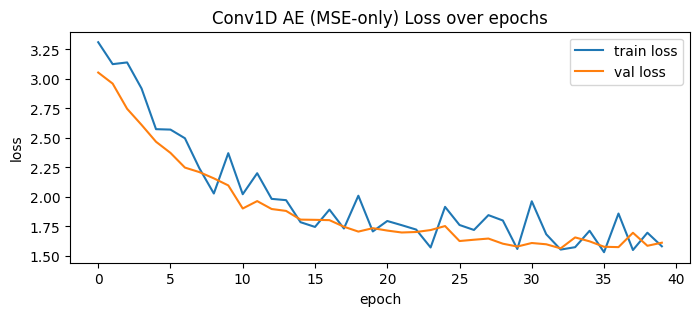

In [40]:
plt.figure(figsize=(8,3))
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.title("Conv1D AE (MSE-only) Loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()


mu mean/std: -0.27853989601135254 10.349211692810059
logvar mean: -9.669482231140137
0 orig max 3.0 recon max 2.551366
1 orig max 2.4313612 recon max 2.66552
2 orig max 1.4480648 recon max 2.4832432


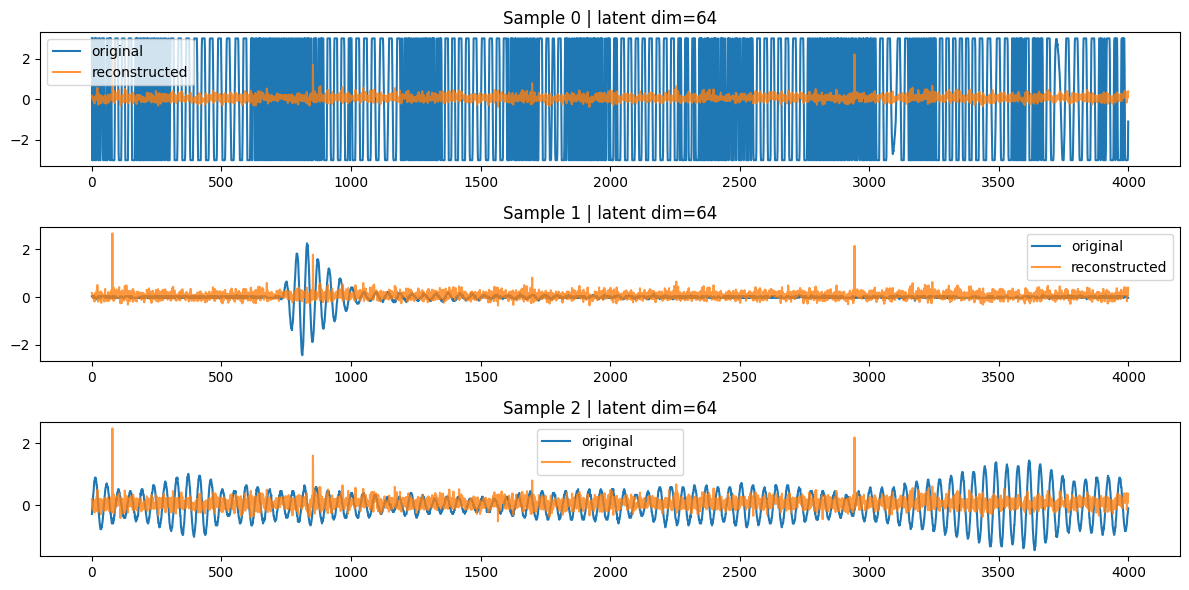

Example latent z[0]: [ -8.912388  -13.938084   15.343915   -7.0165453   7.8646913   9.647813
  -2.9033284 -15.36278   -12.12083   -15.109474   -0.9020451   2.019944
  10.163985   -0.5367425  -2.3488343  12.261771    9.863938    6.7368345
  -4.8109093  -3.7936535  10.937135   14.282615   -8.166117    8.774929
  14.908227   11.371761  -12.164117  -13.886902   10.985865   -7.946993
   7.4351606   7.4312615   7.0380216   5.560235   -1.9609195 -12.396782
  -7.8896747  -5.230371   -8.42055   -11.6074095  -5.2437067 -13.584364
 -13.5622015  -8.467683    4.4093375   8.419033   11.268144    8.756004
   5.337857  -14.86447    -8.911953    8.754456   11.829311   -8.183448
   5.1219063  -6.403181   -5.675399    3.0646312 -10.777822  -13.218537
  -5.0550528  10.324762    9.914021   14.596258 ]


In [41]:
# 从 val 里拿一批
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()

x = next(iter(val_loader))[:3].to(device)  # (3,1,T)

with torch.no_grad():
    x_hat, mu, logvar, z = model(x)
print("mu mean/std:", mu.mean().item(), mu.std().item())
print("logvar mean:", logvar.mean().item())

x_np = x[:,0,:].cpu().numpy()
xhat_np = x_hat[:,0,:].cpu().numpy()

plt.figure(figsize=(12,6))
for i in range(3):
    print(i, "orig max", np.max(np.abs(x_np[i])), "recon max", np.max(np.abs(xhat_np[i])))
    plt.subplot(3,1,i+1)
    plt.plot(x_np[i], label="original")
    plt.plot(xhat_np[i], label="reconstructed", alpha=0.8)
    plt.title(f"Sample {i} | latent dim={latent_dim}")
    plt.legend()
plt.tight_layout()
plt.show()

print("Example latent z[0]:", z[0].cpu().numpy())


In [38]:
import numpy as np
from IPython.display import Audio, display

sr = SR_EXPECT  # 8000

def prep(w):
    w = w.astype(np.float32)

    # 如果在 [0,1]，映射回 [-1,1]
    if w.min() >= 0 and w.max() <= 1.0:
        w = w * 2.0 - 1.0

    m = np.max(np.abs(w)) + 1e-8
    w = w / m
    return np.clip(w, -1.0, 1.0)


i = 2  # 选第几个样本（0/1/2）

orig = prep(x_np[i])
recon = prep(xhat_np[i])

print("Original:")
display(Audio(orig, rate=sr))

print("Reconstruction:")
display(Audio(recon, rate=sr))

# 拼成一个：原声 -> 0.2s 静音 -> 重建（更方便听差异）
silence = np.zeros(int(0.2 * sr), dtype=np.float32)
ab = np.concatenate([orig, silence, recon])
print("A/B combined:")
display(Audio(ab, rate=sr))


Original:


Reconstruction:


A/B combined:


In [ ]:
import soundfile as sf

sf.write(f"{SAVE_DIR}/orig_{RUN_NAME}.wav", orig, sr)
sf.write(f"{SAVE_DIR}/recon_{RUN_NAME}.wav", recon, sr)
sf.write(f"{SAVE_DIR}/AB_{RUN_NAME}.wav", ab, sr)

In [ ]:
print("Quantitative Assessment of Reconstruction Quality (Standard Deviation):")
for i in range(3):
    orig_std = np.std(x_np[i])
    recon_std = np.std(xhat_np[i])
    print(f"Sample {i}: Original STD = {orig_std:.4f}, Reconstructed STD = {recon_std:.4f}")
